## Front Matter

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# parsing/ data gen
import math, random, statistics
from dataclasses import dataclass
import csv
import glob                      # for getting all rcp files from set1
import os
import pandas as pd
import numpy as np
RNG = random.Random(42)          # answer to ultimate question of life, the universe, and everything :)
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# training
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# viz
import matplotlib.pyplot as plt
# shapely additive explanations (SHAP)
import shap
shap.initjs()                     # for interactive plots

##Data Generation

###Details:
One row ~ one project

Features:

- `n_tasks` -> number of activities (project size)
- `n_edges` -> number of precedence links
- `network_density` -> how interconnected the tasks are {n_edges / (n_tasks (n_tasks − 1)/2)}
- `T_baseline` -> total duration from CPM using most-likely (m)
- `cp_len` -> number of tasks on the critical path
- `pct_critical_tasks` -> proportion of critical tasks {`cp_len`/`n_tasks`}
- `avg_task_duration` -> mean(m) across all tasks
- `variability` -> average uncertainty width {mean(p-o)}
- `spi_early` -> {EV/PV} at 20% progress
- `cpi_early` -> {EV/AC} at 20% progress
- `instability_m` -> standard deviation of most likely durations
- `buffer_factor` -> buffer applied to baseline duration for 'on-time' threshold
- `p_late_diag` -> sanity check

Label:
`label_delay` = 1 if p_late > 0.5, 0 otherwise

##Steps:
1. Load and parse the RG30 files
2. Generate PERT triplets
3. Run CPM logic (forward/backward passes)
4. Baseline definition
5. EVM snapshot
6. MC labels
7. Feature engineering
8. Write and load the csv


In [37]:
# parsing one .rcp file and outputs-> durations: dict[int, int]; edges: list[tuple(int, int)]
def read_pat(path, drop_dummies=True):
  durations = {}
  edges = []
  with open(path, "r") as f:
    lines=[l.strip() for l in f if l.strip()]
    # header:
    n_acts, n_res = map(int, lines[0].split())
    # skip line 2:
    index = 2
    # looping through each activity
    for id in range(1, n_acts+1):
      line = lines[index]
      parts = [int(x) for x in line.split()]
      durations[id] = parts[0]                                                        # 1-indexed!!! don't screw up
      index_after_res = n_res+1                                                       # skipping the resources
      k = parts[index_after_res]
      succs = parts[index_after_res+1: index_after_res+1+k]
      for s in succs:
        edges.append((id, s))                                                         # also 1-indexed!!! (as good as R now lol)
      index += 1
    # bye bye dummies
    if drop_dummies:
      actual_ids = list(range(2, n_acts))
      id_map = {old: new for new, old in enumerate(actual_ids, start=1)}               # change ids to one less(2->1, 3->2)
      durations = {id_map[i]: d for i, d in durations.items() if i in id_map}
      edges = [(id_map[u],id_map[v]) for u, v in edges if u in id_map and v in id_map] # remapping edges since new activity ids

    return durations, edges

In [38]:
# assign pert triplets with rules: m = duration from projects; o = max(1, round(0.7*m)); p = max(m+1, round(1.4*m)); o < m < p
@dataclass
class Pert:
  o: float
  m: float
  p: float
def make_triplets(duration: int):
  m = duration
  o = max(1, round(0.7*m))
  p = max(m+1, round(1.4*m))
  return Pert(o, m, p)

In [39]:
# getting predecessors from edgelist
def get_preds(edges, n_tasks):
  preds = [[] for i in range(n_tasks+1)]
  for u, v in edges:
    preds[v].append(u)
  return preds


In [40]:
# cpm: forward pass + backtrack; (ES, EF, T, cp) -> (earliest start, earliest finish, total duration, critical path)
def cpm_early(preds, durations, eps = 1e-9):
  n = len(durations) - 1                                    # 1 indexed!!
  es = [0.0]*(n+1)
  ef = [0.0]*(n+1)
  for i in range(1, n+1):
    if preds[i]:
      es[i] =  max(ef[j] for j in preds[i])
    ef[i] = es[i] + durations[i]
  T = max(ef[1:])                                            # makespan
  # backtrack to get critical path
  cp = []
  i = max(range(1, n + 1), key=lambda k: ef[k])              # position of largest EF (sink)
  while True:
    cp.append(i)                                             # since last task, it definitely on the critical path
    if not preds[i]:
      break
    options = [j for j in preds[i] if abs(ef[i]-ef[j]) < eps]
    if options:
      best_j = max(options, key= lambda j: ef[j])            # for multiple options, pick the one with the longest ef
    else:
      best_j = max(preds[i], key=lambda j: ef[j])            # fallback: pick pred with latest EF
    i = best_j
  cp.reverse()
  return es, ef, T, cp

In [41]:
# getting baseline ES, EF, T, and CP by running CPM on the most likely values (from the triplets)
def baseline_schedule(preds, pert_triplets, n_tasks, buffer_factor, eps = 1e-9):
  # extract most likely durations from Pert objects
  m = [0.0]*(n_tasks+1)
  for i in range(1, n_tasks+1):
    m[i] = pert_triplets[i].m
  # run CPM on m_i
  es_b, ef_b, T_b, cp = cpm_early(preds, m, eps)
  # get deadline = buffer * baseline total duration
  deadline = buffer_factor*T_b
  # building output dictionary
  out ={
      "baseline_T": T_b,
      "baseline_es": es_b,
      "baseline_ef": ef_b,
      "baseline_cp": cp,
      "deadline": deadline,
      "buffer_factor": buffer_factor
  }
  return out


In [42]:
# helper → sample duration d ~ Triangular(o, m, p)
def sample_triangular(pert_triplets):
    n_tasks = len(pert_triplets) - 1          # because index 0 dummy
    d = [0.0] * (n_tasks + 1)
    for i in range(1, n_tasks + 1):
        t = pert_triplets[i]
        d[i] = RNG.triangular(t.o, t.m, t.p)
    return d

In [43]:
# Early EVM snapshot: getting performance indices CPI, SPI
def evm_snapshot(preds, pert_triplets, ef_baseline, T_baseline, frac= 0.20, eps=1e-9):
  # number of real tasks
  n_tasks = len(pert_triplets) - 1
  # early snapshot time
  t_early = T_baseline * frac
  t_early = max(t_early, min(ef_baseline[1:]) + 1e-6)  # ensure >= first planned finish
  # sample duration (single draw)
  d = sample_triangular(pert_triplets)
  # running cpm to get ef_real
  es_real, ef_real, T_real, cp_real = cpm_early(preds, d, eps)
  # defining aggregates-> planned value, earned value, actual cost [no cost data so using time as proxy since +ve corr, BUT can use actual cost data too!]
  pv = 0.0
  ev = 0.0
  ac = 0.0
  for i in range(1, n_tasks + 1):
      t = pert_triplets[i]
      if ef_baseline[i] <= t_early:
          pv += t.m
      if ef_real[i] <= t_early:
          ev += t.m
          ac += d[i]
  # calculating performance indices -> schedule performance index, cost performance index
  spi = ev/max(pv, eps)
  cpi= ev/max(ac, eps)
  # building output dictionary
  out = {
        "t_early": t_early,
        "PV": pv,
        "EV": ev,
        "AC": ac,
        "SPI_early": spi,
        "CPI_early": cpi
        }
  return out


In [44]:
# monte carlo sims
def monte_carlo_label(preds, pert_triplets, deadline, K, eps=1e-9):
  n_tasks = len(pert_triplets) - 1
  # init counter
  count = 0
  # run simulation K times-> sample duration, run cpm to get total duration for each run
  for k in range(K):
    d = sample_triangular(pert_triplets)
    es_k, ef_k, T_k, cp_k = cpm_early(preds, d, eps)
    # increase counter to record number of 'late' projects
    if T_k > deadline:
      count += 1
  # p_late-> fraction of runs that finish late
  p_late = count/K
  label = 1 if p_late >= 0.5 else 0      # label delayed if the prob of delay is more than 0.5

  return p_late, label

In [45]:
# putting it all together-> features for one row of the file
def project_features(preds, edges, pert_triplets, base, snap, p_late, label):
  # structure:
  n_tasks = len(preds) - 1
  n_edges = len(edges)
  max_edges = n_tasks * (n_tasks - 1) / 2
  density   = n_edges / max(max_edges, 1)
  cp = base["baseline_cp"]
  cp_len = len(cp)
  pct_critical_tasks = cp_len/max(n_tasks, 1)
  T_baseline = base["baseline_T"]

  # uncertainty:
  m_list = [pert_triplets[t].m for t in range(1, n_tasks+1)]
  ranges = [pert_triplets[i].p - pert_triplets[i].o for i in range(1, n_tasks + 1)]
  avg_task_duration = statistics.fmean(m_list)
  variability = statistics.fmean(ranges)
  instability = statistics.stdev(m_list) if n_tasks>1 else 0.0

  # performance/early health:
  spi_early = snap["SPI_early"]
  cpi_early = snap["CPI_early"]

  risk_exposure = p_late

  # policy knobs:
  buffer_factor = base["buffer_factor"]

  # building dict:
  row = {
        # structure
        "n_tasks": n_tasks,
        "n_edges": n_edges,
        "density": density,
        "critical_path_len": cp_len,
        "pct_critical_tasks": pct_critical_tasks,
        "T_baseline": T_baseline,

        # uncertainty
        "mean_m": avg_task_duration,
        "mean_range_po": variability,
        "instability_m": instability,

        # early health
        "spi_early": spi_early,
        "cpi_early": cpi_early,

        # policy
        "buffer_factor": buffer_factor,

        # labels/diagnostics
        "label_delay": label,
        "p_late_diag": p_late,
    }
  return row


In [46]:
# build full dataset
def build_data_rangen(path, buffer_factor, K):
  all_files = glob.glob(path + "/*.rcp")
  all_files.sort()
  print(f"Found {len(all_files)} .rcp files")

  rows = []

  for file_path in all_files:
      # --- parse this .rcp file ---
      durations, edges = read_pat(file_path, drop_dummies=True)
      n_tasks = len(durations)

      # preds
      preds = get_preds(edges, n_tasks)

      # PERT triplets (1-indexed list)
      triplets = [None] * (n_tasks + 1)
      for i in range(1, n_tasks + 1):
          triplets[i] = make_triplets(durations[i])

      # baseline schedule
      base = baseline_schedule(
          preds,
          triplets,
          n_tasks,
          buffer_factor=buffer_factor
      )

      # EVM snapshot
      snap = evm_snapshot(
          preds,
          triplets,
          base["baseline_ef"],
          base["baseline_T"]
      )

      # Monte Carlo
      p_late, label = monte_carlo_label(
          preds,
          triplets,
          base["deadline"],
          K,
      )

      # one feature row
      row = project_features(preds, edges, triplets, base, snap, p_late, label)

      rows.append(row)

  print(f"Built {len(rows)} rows")
  return rows


In [47]:
# write to csv:
def write_csv(rows, path, round_cols):

    # rounding
    if round_cols:
        for r in rows:
            for c in round_cols:
                if c in r and isinstance(r[c], float):
                    r[c] = round(r[c], 3)

    # fields= first row
    fields = list(rows[0].keys())

    with open(path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fields)
        w.writeheader()
        w.writerows(rows)

In [48]:
if __name__ == "__main__":

  RNG.seed(42)

  # folder with your .rcp files (Set 1)
  folder = "/content/drive/MyDrive/Set 1"

  rows = build_data_rangen(
      path=folder,
      buffer_factor=1.01, # 1% buffer
      K=200,
  )

  pretty_cols = [
      "T_baseline",
      "mean_m",
      "mean_range_po",
      "spi_early",
      "cpi_early",
      "instability_m",
      "density",
      "pct_critical_tasks",
      "buffer_factor",
      "p_late_diag",
  ]

  out_csv = "rg30_set1_duplicate.csv"
  write_csv(rows, out_csv, round_cols=pretty_cols)

  print(f"Wrote {len(rows)} rows -> {out_csv}")
  pos = sum(r["label_delay"] for r in rows)
  print(f"label 1s: {pos}/{len(rows)} = {pos/len(rows):.2f}")


Found 900 .rcp files
Built 900 rows
Wrote 900 rows -> rg30_set1_duplicate.csv
label 1s: 465/900 = 0.52


##Data Preprocessing

In [49]:
# reading it in
df1 = pd.read_csv("/content/drive/MyDrive/rg30_set1.csv")
df1.head()

,n_tasks,n_edges,density,critical_path_len,pct_critical_tasks,T_baseline,mean_m,mean_range_po,instability_m,spi_early,cpi_early,buffer_factor,label_delay,p_late_diag
0,30,28,0.064,2,0.067,20.0,5.467,3.867,3.014,0.765,1.093,1.01,1,0.535
1,30,54,0.124,3,0.100,22.0,5.667,4.067,2.324,0.692,1.069,1.01,1,0.615
2,30,194,0.446,3,0.100,27.0,5.533,3.933,2.315,4.000,1.186,1.01,1,0.610
3,30,43,0.099,6,0.200,26.0,5.167,3.667,2.705,0.654,0.961,1.01,1,0.625
4,30,50,0.115,6,0.200,31.0,5.667,4.067,2.881,0.680,0.973,1.01,0,0.485


In [50]:
# dropping columns that can lead to leakage
df = df1.copy()
# p_late diag is as good as the target, buffer is design choice, number of tasks is constant and has no correlation w label
df = df.drop(columns= ["p_late_diag", "buffer_factor", "n_tasks"])
# fix outliers for cpi and spi
df["spi_early"] = df["spi_early"].clip(0, 2)
df["cpi_early"] = df["cpi_early"].clip(0, 2)
# split x and y
y = df["label_delay"]
X = df.drop(columns=["label_delay"])
# stratified split 1: df-> train and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# stratified split 2: temp-> val and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# scale X_train, X_val, X_test for logistic
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [51]:
# sanity o_O
X_train.shape, X_val.shape, X_test.shape

((630, 10), (135, 10), (135, 10))

## Model Selection


In [52]:
# LOGISTIC REGRESSION
log_reg = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
# hard preds:
y_val_preds_lr = log_reg.predict(X_val_scaled)
# probs of preds:
y_val_probs_lr = log_reg.predict_proba(X_val_scaled)[:, 1]

# eval
acc_log = accuracy_score(y_val, y_val_preds_lr)
f1_log = f1_score(y_val, y_val_preds_lr)
roc_auc_log = roc_auc_score(y_val, y_val_probs_lr)
print("LR-> Validation Metrics:")
print(f"Accuracy: {acc_log:.2f}")
print(f"F1 Score: {f1_log:.2f}")
print(f"ROC-AUC score: {roc_auc_log:.2f}")


LR-> Validation Metrics:
Accuracy: 0.69
F1 Score: 0.71
ROC-AUC score: 0.74


In [53]:
# NAIVE BAYES
nb = GaussianNB().fit(X_train, y_train)
# hard preds
y_val_preds_nb = nb.predict(X_val)
# probs of preds
y_val_probs_nb = nb.predict_proba(X_val)[:, 1]

# eval
acc_nb = accuracy_score(y_val, y_val_preds_nb)
f1_nb = f1_score(y_val, y_val_preds_nb)
roc_auc_nb = roc_auc_score(y_val, y_val_probs_nb)
print("NB-> Validation Metrics:")
print(f"Accuracy: {acc_nb:.2f}")
print(f"F1 Score: {f1_nb:.2f}")
print(f"ROC-AUC score: {roc_auc_nb:.2f}")



NB-> Validation Metrics:
Accuracy: 0.65
F1 Score: 0.64
ROC-AUC score: 0.71


In [54]:
# RANDOM FOREST
rf = RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_leaf=5, max_features= None, random_state=42).fit(X_train, y_train)
# hard preds
y_val_preds_rf = rf.predict(X_val)
# probs of preds
y_val_probs_rf = rf.predict_proba(X_val)[:, 1]

# eval
acc_rf = accuracy_score(y_val, y_val_preds_rf)
f1_rf = f1_score(y_val, y_val_preds_rf)
roc_auc_rf = roc_auc_score(y_val, y_val_probs_rf)
print("RF-> Validation Metrics:")
print(f"Accuracy: {acc_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")
print(f"ROC-AUC score: {roc_auc_rf:.2f}")

RF-> Validation Metrics:
Accuracy: 0.73
F1 Score: 0.75
ROC-AUC score: 0.74


In [55]:
# validation summary data
val_summary= pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes", "Random Forest"],
    "Accuracy": [acc_log, acc_nb, acc_rf],
    "F1 Score": [f1_log, f1_nb, f1_rf],
    "ROC-AUC": [roc_auc_log, roc_auc_nb, roc_auc_rf]
})
val_summary.style.format({
    "Accuracy": "{:.2f}",
    "F1 Score": "{:.2f}",
    "ROC-AUC": "{:.2f}"
    })

,Model,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,0.69,0.71,0.74
1,Naive Bayes,0.65,0.64,0.71
2,Random Forest,0.73,0.75,0.74


## Analytical Baselines

Two analytical baselines are chosen:

- predict delay based on `spi_early`-> emulates fuzzy EVM
- predict delay based on purely structural features



In [56]:
# baseline A
spi_20 = df['spi_early']
spi_scores = [1 if spi_20[i]>1 else 0 for i in y_test.index]
acc_A = accuracy_score(y_test, spi_scores)
f1_A = f1_score(y_test, spi_scores)
roc_auc_A = roc_auc_score(y_test, spi_scores)
print("Baseline A-> Metrics:\n")
print(f"Accuracy: {acc_A:.2f}")
print(f"F1 Score: {f1_A:.2f}")
print(f"ROC-AUC score: {roc_auc_A:.2f}")

Baseline A-> Metrics:

Accuracy: 0.50
F1 Score: 0.26
ROC-AUC score: 0.50


In [57]:
# baseline B
# getting relevant features
X_test_B = X_test_scaled[:, 1:5]
X_train_B = X_train_scaled[:, 1:5]
X_val_B = X_val_scaled[:, 1:5]


# building LR
logreg_B = LogisticRegression(random_state=42).fit(X_train_B, y_train)

# validation
# hard preds:
y_val_preds_B = logreg_B.predict(X_val_B)
# probs of preds:
y_val_probs_B = logreg_B.predict_proba(X_val_B)[:, 1]

# eval on val
acc_log_B = accuracy_score(y_val, y_val_preds_B)
f1_log_B = f1_score(y_val, y_val_preds_B)
roc_auc_log_B = roc_auc_score(y_val, y_val_probs_B)
print("Baseline B-> Eval Metrics Validation:")
print(f"Accuracy: {acc_log_B:.2f}")
print(f"F1 Score: {f1_log_B:.2f}")
print(f"ROC-AUC score: {roc_auc_log_B:.2f}\n")

# test
# hard preds:
y_test_preds_B = logreg_B.predict(X_test_B)
# probs of preds:
y_test_probs_B = logreg_B.predict_proba(X_test_B)[:, 1]
# eval on test
acc_B = accuracy_score(y_test, y_test_preds_B)
f1_B = f1_score(y_test, y_test_preds_B)
roc_auc_B = roc_auc_score(y_test, y_test_probs_B)
print("\nBaseline B-> Eval Metrics Test:")
print(f"Accuracy: {acc_B:.2f}")
print(f"F1 Score: {f1_B:.2f}")
print(f"ROC-AUC score: {roc_auc_B:.2f}")


Baseline B-> Eval Metrics Validation:
Accuracy: 0.68
F1 Score: 0.70
ROC-AUC score: 0.71


Baseline B-> Eval Metrics Test:
Accuracy: 0.68
F1 Score: 0.70
ROC-AUC score: 0.75


In [58]:
# testing!
# get preds and probs
y_test_preds_rf = rf.predict(X_test)
y_test_probs_rf = rf.predict_proba(X_test)[:, 1]

acc_rf_test = accuracy_score(y_test, y_test_preds_rf)
f1_rf_test = f1_score(y_test, y_test_preds_rf)
roc_auc_rf_test = roc_auc_score(y_test, y_test_probs_rf)
print("RF-> Testing Metrics:")
print(f"Accuracy: {acc_rf_test:.2f}")
print(f"F1 Score: {f1_rf_test:.2f}")
print(f"ROC-AUC score: {roc_auc_rf_test:.2f}")

RF-> Testing Metrics:
Accuracy: 0.69
F1 Score: 0.70
ROC-AUC score: 0.76


In [59]:
# summary table comparing RF and the two analytical baselines
test_summary= pd.DataFrame({
    "Method": ["Early SPI", "Structural Inference- Logistic Regression ", "Random Forest"],
    "Accuracy": [acc_A, acc_B, acc_rf_test],
    "F1 Score": [f1_A, f1_B, f1_rf_test],
    "ROC-AUC": [roc_auc_A, roc_auc_B, roc_auc_rf_test]
})
test_summary.style.format({
    "Accuracy": "{:.3f}",
    "F1 Score": "{:.3f}",
    "ROC-AUC": "{:.3f}"
    })

,Method,Accuracy,F1 Score,ROC-AUC
0,Early SPI,0.496,0.261,0.504
1,Structural Inference- Logistic Regression,0.681,0.699,0.748
2,Random Forest,0.689,0.700,0.758


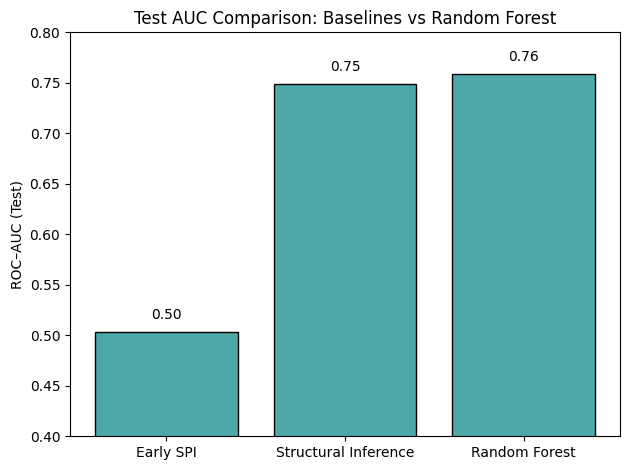

In [60]:
# bar chart for all three methods
methods = ["Early SPI", "Structural Inference", "Random Forest"]
roc_auc = [roc_auc_A, roc_auc_B, roc_auc_rf_test]
fig, ax = plt.subplots()
ax.bar(methods, roc_auc, color= "#4DA8A9", edgecolor= "black")
ax.set_ylabel("ROC-AUC")
ax.set_ylim(0.4, 0.8)
ax.set_ylabel("ROC–AUC (Test)")
ax.set_title("Test AUC Comparison: Baselines vs Random Forest")
for i, v in enumerate(roc_auc):
    ax.text(
        i,
        v + 0.01,
        f"{v:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )
fig.tight_layout()

## Feature Importance and SHAP

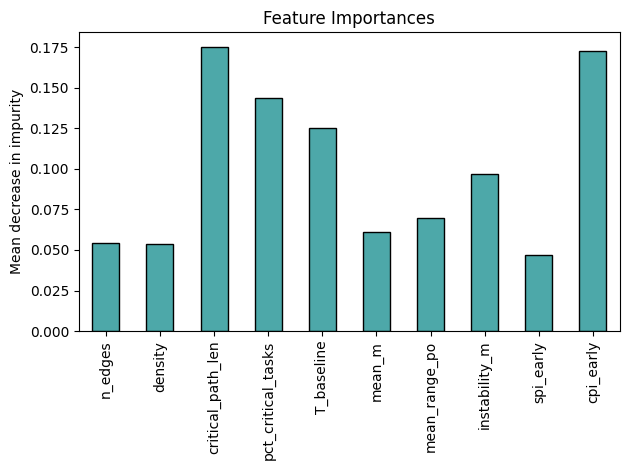

In [61]:
# getting features, importances per feature, standard deviation
features = list(X_train.columns)
importances = rf.feature_importances_
std = np.std([i.feature_importances_ for i in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)

# plot
fig, ax = plt.subplots()
forest_importances.plot.bar(y=std, ax=ax, color="#4DA8A9", edgecolor= "black")
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [62]:
# SHAP
# randomly sample from X_train, full thing not needed
X_sample= X_train.sample(n=200, random_state=42)
# create an explainer-> let shap learn how the trees split so it can attribute importance
explainer = shap.TreeExplainer(rf)
# get the shap values-> gives list w an array per class
shap_vals = explainer.shap_values(X_sample)
# shap_vals has shape (n_samples, n_features, n_classes); use class 1 ("delay")
shap_vals_1 = shap_vals[:, :, 1]                        # slicing to get only values associated with the instances labeled as delayed


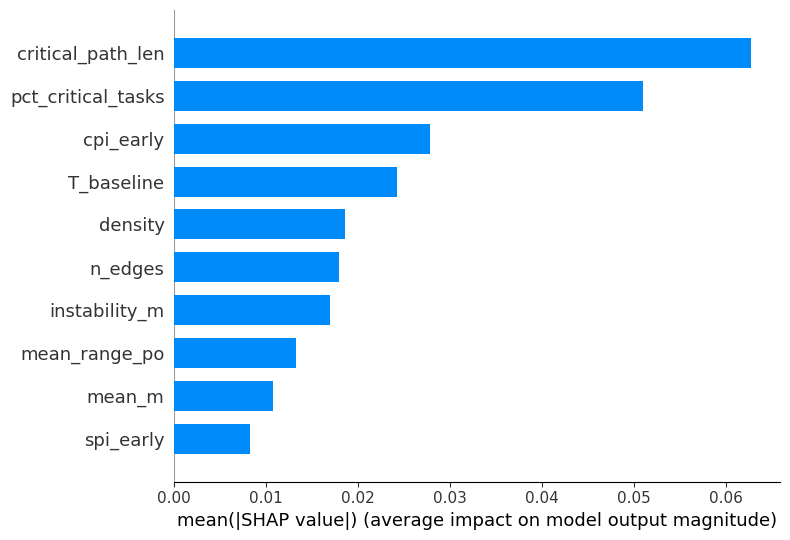

In [63]:
shap.summary_plot(shap_vals_1, X_sample, plot_type="bar")

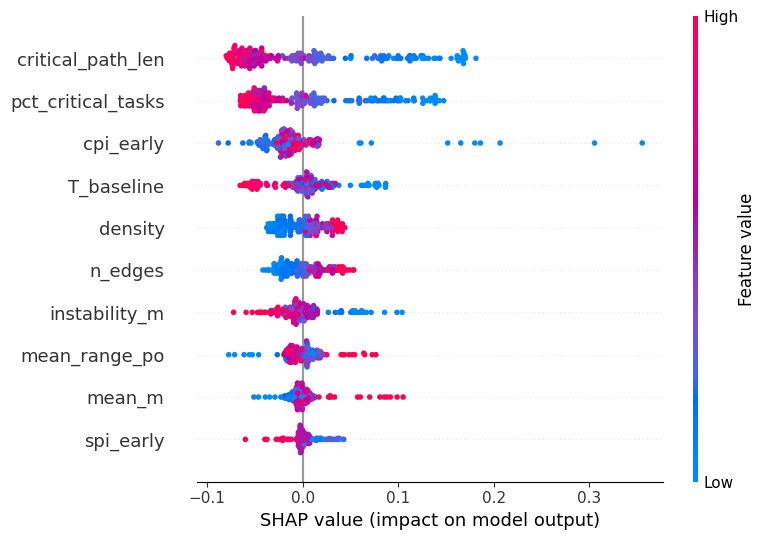

In [64]:
shap.summary_plot(shap_vals_1, X_sample)
